In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score


In [2]:
df = pd.read_csv("Fish.csv")
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
df = df[df['Weight'] > 0]

In [4]:
df.shape

(158, 7)

In [5]:
X = df[['Length3']]   # variable explicativa
y = df['Weight']      # variable dependiente

In [6]:
X_log = np.log(X)   # logaritmo de la longitud
y_log = np.log(y)   # logaritmo del peso

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=43)

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [9]:
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 0.24732248896901154
R2 Score: 0.9391278263249206


In [10]:
print("Intercepto:", model.intercept_)
print("Coeficiente:", model.coef_)

Intercepto: -5.460952320023237
Coeficiente: [3.22434804]


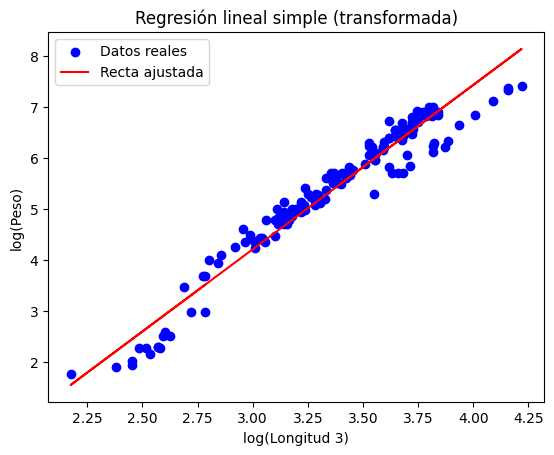

In [11]:
plt.scatter(X_log, y_log, color="blue", label="Datos reales")
plt.plot(X_log, model.predict(X_log), color="red", label="Recta ajustada")
plt.xlabel("log(Longitud 3)")
plt.ylabel("log(Peso)")
plt.title("Regresión lineal simple (transformada)")
plt.legend()
plt.show()


POr especies


In [15]:

results = {}

for species in df['Species'].unique():
    # Filtrar por especie
    df_species = df[df['Species'] == species]
    
    # Variables
    X = np.log(df_species[['Length3']])
    y = np.log(df_species['Weight'])
    
    # Ajustar modelo
    model = LinearRegression()
    model.fit(X, y)
    
    # Predicciones
    y_pred = model.predict(X)
    
    # Evaluación
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Guardar resultados
    results[species] = {
        'Intercepto': model.intercept_,
        'Coeficiente': model.coef_[0],
        'MAE': mae,
        'R2': r2
    }

# Mostrar resultados
for species, res in results.items():
    print(f"Especie: {species}")
    print(f"  Intercepto: {res['Intercepto']:.4f}")
    print(f"  Coeficiente: {res['Coeficiente']:.4f}")
    print(f"  MAE: {res['MAE']:.4f}")
    print(f"  R2: {res['R2']:.4f}")
    print("-"*40)

Especie: Bream
  Intercepto: -5.0508
  Coeficiente: 3.1354
  MAE: 0.0833
  R2: 0.8901
----------------------------------------
Especie: Roach
  Intercepto: -5.0252
  Coeficiente: 3.1082
  MAE: 0.0899
  R2: 0.9601
----------------------------------------
Especie: Whitefish
  Intercepto: -5.7044
  Coeficiente: 3.3600
  MAE: 0.0663
  R2: 0.9777
----------------------------------------
Especie: Parkki
  Intercepto: -4.5280
  Coeficiente: 3.0342
  MAE: 0.0607
  R2: 0.9796
----------------------------------------
Especie: Perch
  Intercepto: -5.0788
  Coeficiente: 3.1627
  MAE: 0.0814
  R2: 0.9890
----------------------------------------
Especie: Pike
  Intercepto: -6.0066
  Coeficiente: 3.2011
  MAE: 0.0734
  R2: 0.9799
----------------------------------------
Especie: Smelt
  Intercepto: -5.2683
  Coeficiente: 2.9768
  MAE: 0.0850
  R2: 0.9138
----------------------------------------


Bandas de confianza

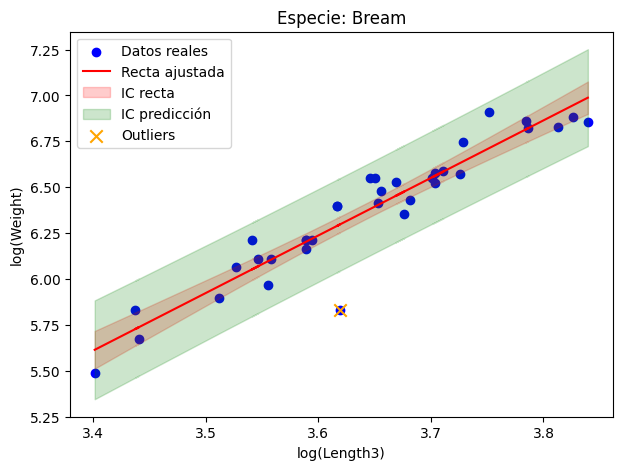

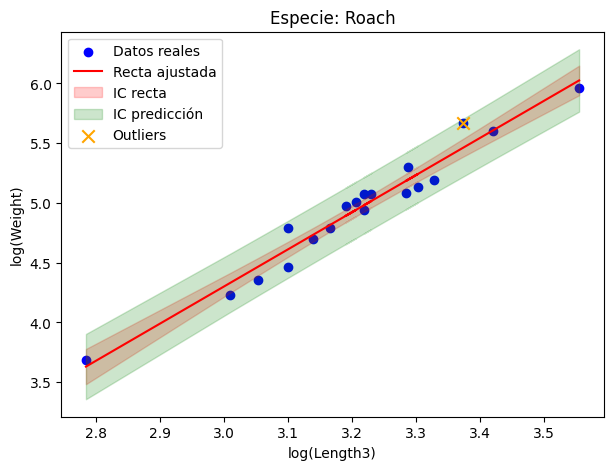

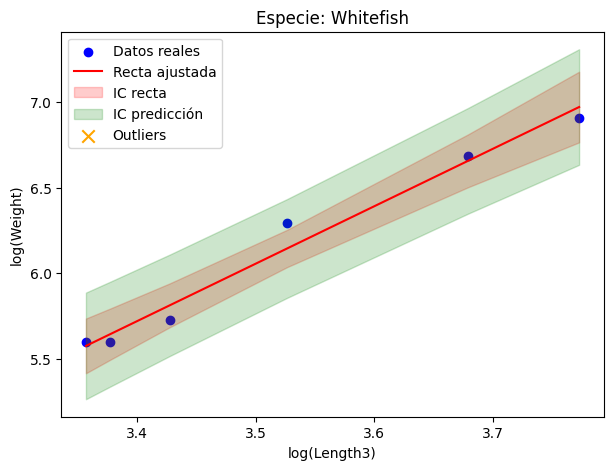

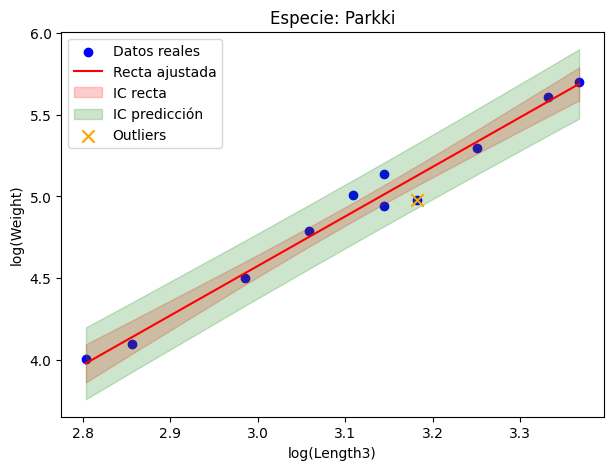

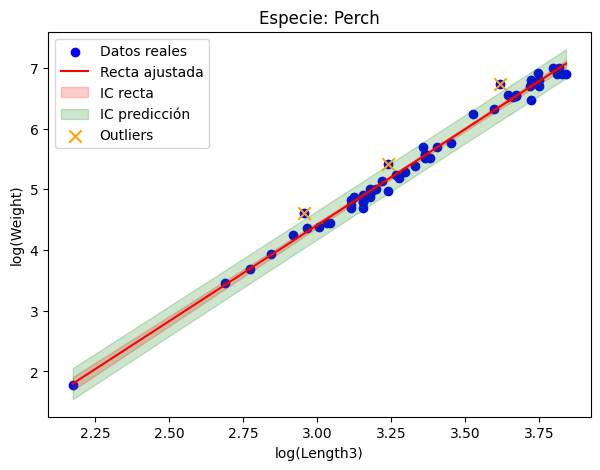

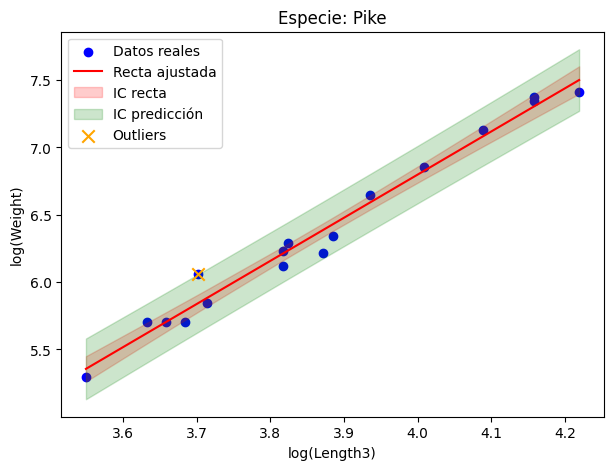

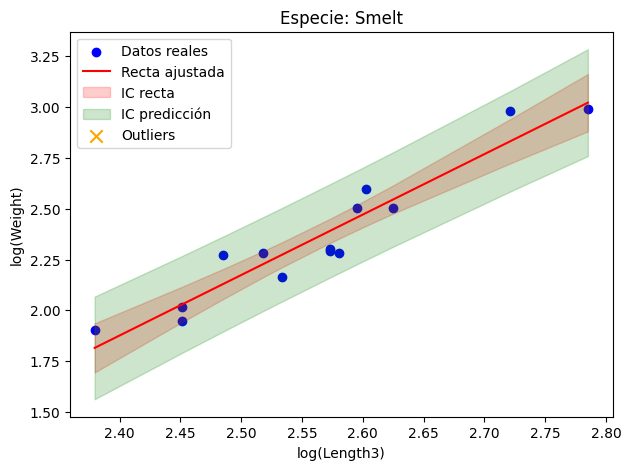

In [16]:
import statsmodels.api as sm

species_results = {}

for species in df['Species'].unique():
    df_species = df[df['Species'] == species]
    
    # Variables transformadas
    X = np.log(df_species[['Length3']])
    y = np.log(df_species['Weight'])
    
    # Ajuste con statsmodels (más flexible para intervalos)
    X_sm = sm.add_constant(X)  # agrega intercepto
    model = sm.OLS(y, X_sm).fit()
    
    # Predicciones y bandas
    predictions = model.get_prediction(X_sm)
    pred_summary = predictions.summary_frame(alpha=0.05)  # 95% IC
    
    # Detectar outliers
    residuals = model.resid
    std_resid = residuals / np.std(residuals)
    outliers = df_species[np.abs(std_resid) > 2]
    
    # Guardar resultados
    species_results[species] = {
        "params": model.params,
        "conf_int": model.conf_int(),
        "outliers": outliers
    }
    
    # Gráfico
    plt.figure(figsize=(7,5))
    plt.scatter(X, y, label="Datos reales", color="blue")
    plt.plot(X, pred_summary['mean'], color="red", label="Recta ajustada")
    plt.fill_between(X.squeeze(), 
                     pred_summary['mean_ci_lower'], 
                     pred_summary['mean_ci_upper'], 
                     color="red", alpha=0.2, label="IC recta")
    plt.fill_between(X.squeeze(), 
                     pred_summary['obs_ci_lower'], 
                     pred_summary['obs_ci_upper'], 
                     color="green", alpha=0.2, label="IC predicción")
    plt.scatter(np.log(outliers['Length3']), np.log(outliers['Weight']), 
                color="orange", label="Outliers", marker="x", s=80)
    plt.xlabel("log(Length3)")
    plt.ylabel("log(Weight)")
    plt.title(f"Especie: {species}")
    plt.legend()
    plt.show()

Variable “Width” como respuesta y Height como variable explicativa

In [17]:

# Variables
X = df[['Height']]
y = df['Width']

# Transformación logarítmica
X_log = np.log(X)
y_log = np.log(y)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=43)

# Ajuste del modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
print("Intercepto:", model.intercept_)
print("Coeficiente:", model.coef_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Intercepto: -0.167269008472553
Coeficiente: [0.76388153]
MAE: 0.18002341810684452
R2 Score: 0.7566042816611518


In [18]:
results = {}

for species in df['Species'].unique():
    df_species = df[df['Species'] == species]
    
    X = np.log(df_species[['Height']])
    y = np.log(df_species['Width'])
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    results[species] = {
        'Intercepto': model.intercept_,
        'Coeficiente': model.coef_[0],
        'MAE': mae,
        'R2': r2
    }

for species, res in results.items():
    print(f"Especie: {species}")
    print(f"  Intercepto: {res['Intercepto']:.4f}")
    print(f"  Coeficiente: {res['Coeficiente']:.4f}")
    print(f"  MAE: {res['MAE']:.4f}")
    print(f"  R2: {res['R2']:.4f}")
    print("-"*40)

Especie: Bream
  Intercepto: -0.8939
  Coeficiente: 0.9501
  MAE: 0.0400
  R2: 0.8467
----------------------------------------
Especie: Roach
  Intercepto: -0.5116
  Coeficiente: 0.9522
  MAE: 0.0441
  R2: 0.9101
----------------------------------------
Especie: Whitefish
  Intercepto: -1.0262
  Coeficiente: 1.1808
  MAE: 0.0363
  R2: 0.9326
----------------------------------------
Especie: Parkki
  Intercepto: -1.1893
  Coeficiente: 1.0746
  MAE: 0.0344
  R2: 0.9462
----------------------------------------
Especie: Perch
  Intercepto: -0.4811
  Coeficiente: 0.9873
  MAE: 0.0529
  R2: 0.9680
----------------------------------------
Especie: Pike
  Intercepto: -0.4013
  Coeficiente: 0.9917
  MAE: 0.0521
  R2: 0.9146
----------------------------------------
Especie: Smelt
  Intercepto: -0.5355
  Coeficiente: 1.0368
  MAE: 0.0824
  R2: 0.7139
----------------------------------------


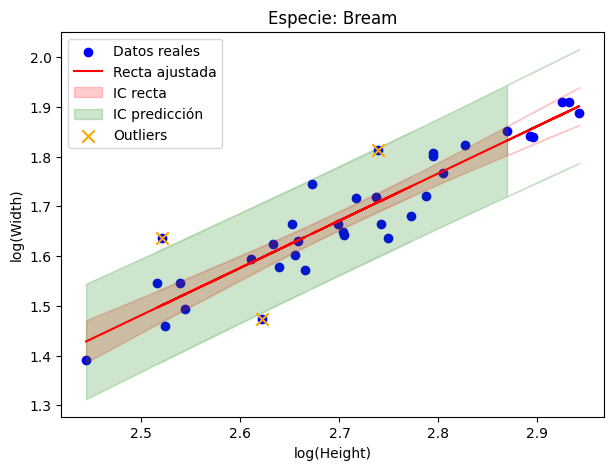

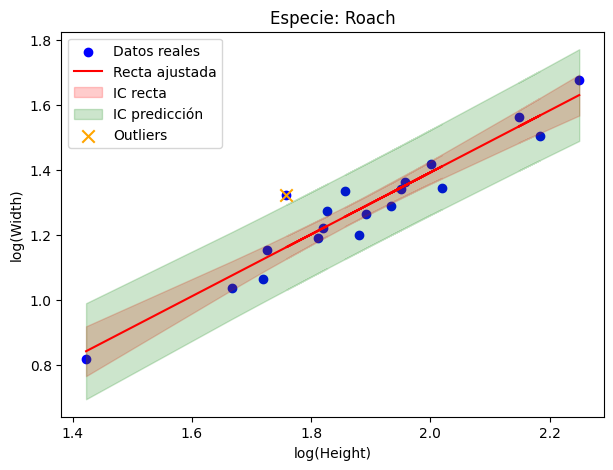

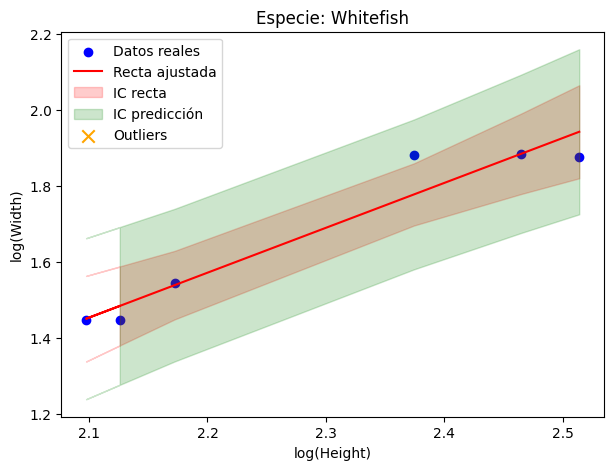

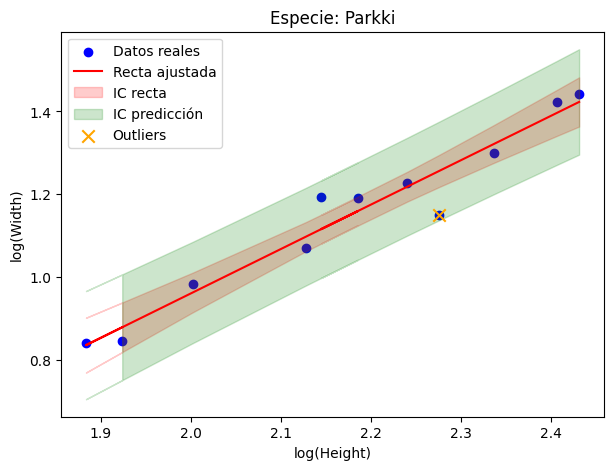

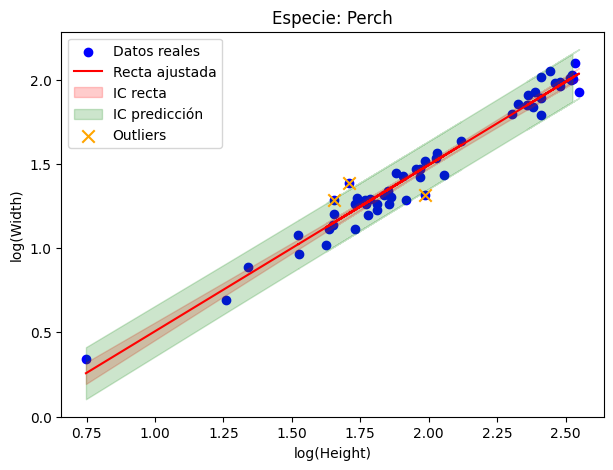

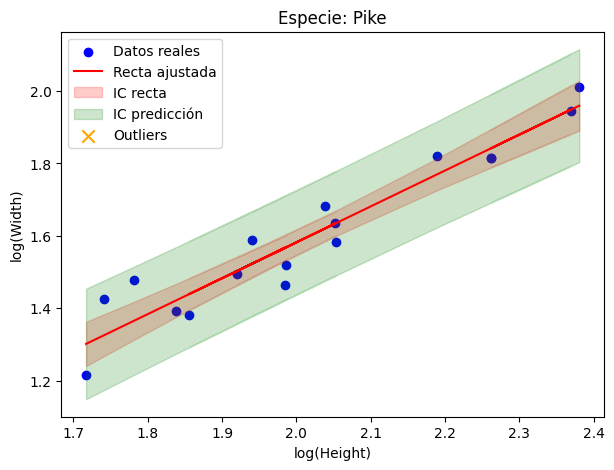

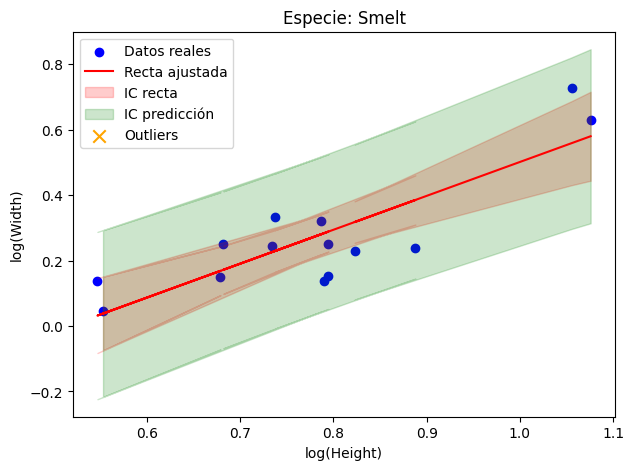

In [19]:

for species in df['Species'].unique():
    df_species = df[df['Species'] == species]
    
    X = np.log(df_species[['Height']])
    y = np.log(df_species['Width'])
    
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    
    predictions = model.get_prediction(X_sm)
    pred_summary = predictions.summary_frame(alpha=0.05)  # 95% IC
    
    # Outliers: residuos estandarizados
    residuals = model.resid
    std_resid = residuals / np.std(residuals)
    outliers = df_species[np.abs(std_resid) > 2]
    
    # Gráfico
    plt.figure(figsize=(7,5))
    plt.scatter(X, y, label="Datos reales", color="blue")
    plt.plot(X, pred_summary['mean'], color="red", label="Recta ajustada")
    plt.fill_between(X.squeeze(), 
                     pred_summary['mean_ci_lower'], 
                     pred_summary['mean_ci_upper'], 
                     color="red", alpha=0.2, label="IC recta")
    plt.fill_between(X.squeeze(), 
                     pred_summary['obs_ci_lower'], 
                     pred_summary['obs_ci_upper'], 
                     color="green", alpha=0.2, label="IC predicción")
    plt.scatter(np.log(outliers['Height']), np.log(outliers['Width']), 
                color="orange", label="Outliers", marker="x", s=80)
    plt.xlabel("log(Height)")
    plt.ylabel("log(Width)")
    plt.title(f"Especie: {species}")
    plt.legend()
    plt.show()